In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00


In [2]:
import transformers

In [3]:
print(transformers.__version__)

4.34.0


In [4]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_csv('bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
df.shape

(2225, 2)

In [7]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [8]:
df.head()

,category,text,count
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260


<Figure size 800x800 with 0 Axes>

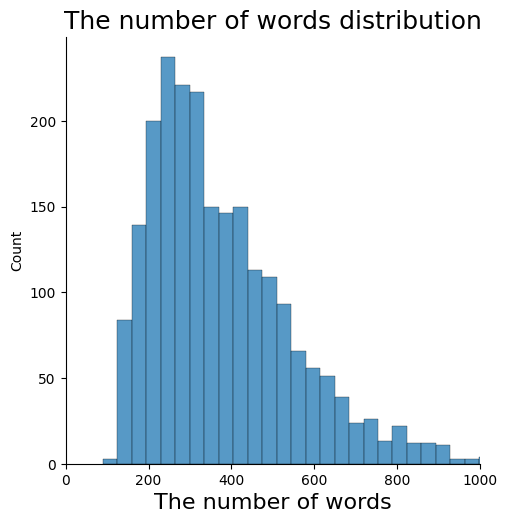

In [9]:
plt.figure(figsize=(8,8))
sns.displot(df['count'])
plt.xlim(0, 1000)
plt.xlabel('The number of words', fontsize=16)
plt.title('The number of words distribution', fontsize=18)
plt.show()

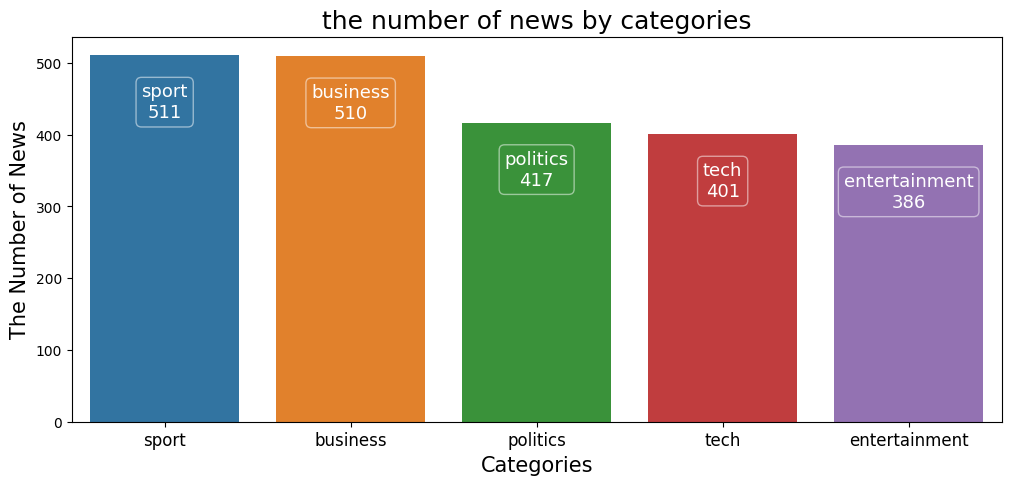

In [10]:
categories=df['category'].value_counts().index
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
sns.barplot(x = df['category'].value_counts().index, y=df['category'].value_counts())

for a, p in enumerate(ax.patches):
  ax.annotate(f'{categories[a]}\n' + format(p.get_height(),'.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext=(0,-45), size = 13, color = 'white', ha='center', textcoords='offset points', bbox=dict(boxstyle='round', facecolor='none', edgecolor='white', alpha=0.5))

plt.xlabel('Categories', size=15)
plt.ylabel('The Number of News', size=15)
plt.xticks(size=12)
plt.title('the number of news by categories', size=18)
plt.show()

In [11]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [12]:
df['encoded_cat'] = df['category'].astype('category').cat.codes

df.head()

,category,text,count,encoded_cat
0,tech,tv future in the hands of viewers with home th...,737,4
1,business,worldcom boss left books alone former worldc...,300,0
2,sport,tigers wary of farrell gamble leicester say ...,246,3
3,sport,yeading face newcastle in fa cup premiership s...,341,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,1


In [13]:
data_texts = df['text'].to_list()

data_labels = df['encoded_cat'].to_list()

In [14]:
# Train test split

train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)


In [15]:
# Model Definition

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, padding=True, truncation=True)

val_encodings = tokenizer(val_texts, padding=True, truncation=True)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [17]:
# fine tuning with tftrainer class
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=1e-5,
    logging_dir='./logs',
    eval_steps=100,
)

with training_args.strategy.scope():
  trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

trainer = TFTrainer(
    model = trainer_model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [18]:
trainer.train()

In [19]:
trainer.evaluate()

{'eval_loss': 0.028091111353465488}

In [20]:
save_directory = "./saved_models"
trainer_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./saved_models/tokenizer_config.json',
 './saved_models/special_tokens_map.json',
 './saved_models/vocab.txt',
 './saved_models/added_tokens.json')

In [22]:
# Loading fine tuned model
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at ./saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able t

In [24]:
test_text = test_texts[0]
test_text

'dollar hovers around record lows the us dollar hovered close to record lows against the euro on friday as concern grows about the size of the us budget deficit.  analysts predict that the dollar will remain weak in 2005 as investors worry about the state of the us economy. the bush administration s apparent unwillingness to intervene to support the dollar has caused further concern. however  trading has been volatile over the past week because of technical and automated trading and light demand. this has amplified reactions to news  analysts said  adding that they expect markets to become less jumpy in january.  the dollar was trading at $1.3652 versus the euro on friday morning after hitting a fresh record low of $1.3667 on thursday. one dollar bought 102.55 yen.  disappointing business figures from chicago triggered the us currency s weakness on thursday. the national association of purchasing management-chicago said its manufacturing index dropped to 61.2  a bigger fall than expect

In [31]:
predict_input = tokenizer_fine_tuned.encode(test_text,
                                            truncation=True,
                                            padding=True,
                                            return_tensors='tf')
output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

prediction_value

0

In [27]:
# Inferencing with Pytorch

import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All TF 2.0 model weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [30]:
predict_input_pt = tokenizer_fine_tuned_pt.encode(test_text,
                                            truncation=True,
                                            padding=True,
                                            return_tensors='pt')
output_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(output_pt[0], dim=1).item()

prediction_value_pt

0